In [82]:
# General imports
import pickle
import copy
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from collections import namedtuple, deque
from copy import deepcopy, copy
import random

# Pytorch imports
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from lunar_lander import LunarLander

In [2]:
print(f'Installed GYM version is: {gym.__version__}')

Installed GYM version is: 0.26.2


Change default plotting parameters

In [3]:
# Set Seaborn aesthetics
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.style.use('ggplot')

# Environment

In [4]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')

In [6]:
print(f'Reward threshold is: {env.spec.reward_threshold}')
print(f'Reward range is: {env.reward_range}')
print(f'Maximun number of steps per episode: {env.spec.max_episode_steps}')
print(f'Action space dimension is: {env.action_space.n}')
print(f'Observation space dimension is: {env.observation_space.shape}')

Reward threshold is: 200
Reward range is: (-inf, inf)
Maximun number of steps per episode: 1000
Action space dimension is: 4
Observation space dimension is: (8,)


Las 4 acciones disponibles son:
* 0: No hacer nada
* 1: Encender el motor izquierdo
* 2: Encender el motor principal (bajo la nave)
* 3: Encender el motor derecho

Vemos que el estado es un vector de 8 elementos, que son, segun la [documentación de OpenAI](https://www.gymlibrary.dev/environments/box2d/lunar_lander/):
1. Posición en x
2. Posición en y
3. Velocidad en x
4. Velocidad en y
5. Ángulo
6. Velocidad angular
7. Booleano que indica si la pata izquierda está en contacto con el suelo
8. Booleano que indica si la pata derecha está en contacto con el suelo

In [12]:
class randAgent():
    '''Class for a random agent.'''
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space.n
        self.observation_space = env.observation_space.shape[0]
    
    
    def get_action(self, state):
        return self.env.action_space.sample()


In [27]:
def play_episode(env:gym.Env, agent, save:bool = False) -> tuple[float, int]:
    '''Plays a random episode and returns the total reward and number of steps taken'''

    obs = env.reset()[0]
    total_reward, done, steps = 0, False, 0
    frames = []
    
    def _label_with_text(frame):
        '''
        frame: gym environment frame
        '''
        im = Image.fromarray(frame)
        im = im.resize((im.size[0]*2,im.size[1]*2))
        drawer = ImageDraw.Draw(im)
        drawer.text((1, 1), "UOC Aprendizaje Por Refuerzo. Gerson Villalba Arana", 
                    fill=(255, 255, 255, 128))
        return im
    
    while not done:
        # Get action from agent
        action = agent.get_action(obs)
        if save:
            frame = env.render()
            frames.append(_label_with_text(frame))
        # Take step in environment
        new_obs, reward, done, info, _ = env.step(action)
        # Update state, counter and total reward
        obs = new_obs
        steps += 1
        total_reward += reward

    env.close()
    if save:
        filename = 'lunar_lander_' + agent.__class__.__name__ + '.gif'
        imageio.mimwrite(Path('videos') / filename, frames, fps=60)
    return total_reward, steps

In [29]:
random_agent = randAgent(env)
total_reward, steps = play_episode(env, random_agent, save=True)
print(f'Total reward: {total_reward}, Steps: {steps}')

Total reward: -119.17973148851078, Steps: 71


Play several games with the random agent to see how the environment works.

In [30]:
def play_episodes(env:gym.Env, agent, n_episodes:int) -> tuple[np.ndarray, np.ndarray]:
    '''Plays n_episodes random episodes and returns the total reward and number of steps taken'''
    total_rewards = []
    n_steps = []
    for i in tqdm(range(n_episodes)):
        total_reward, steps = play_episode(env, agent, save=False)
        total_rewards.append(total_reward)
        n_steps.append(steps)
    return np.array(total_rewards), np.array(n_steps)


n_episodes = 1000
total_rewards, n_steps = play_episodes(env, random_agent, n_episodes)

  0%|          | 0/1000 [00:00<?, ?it/s]

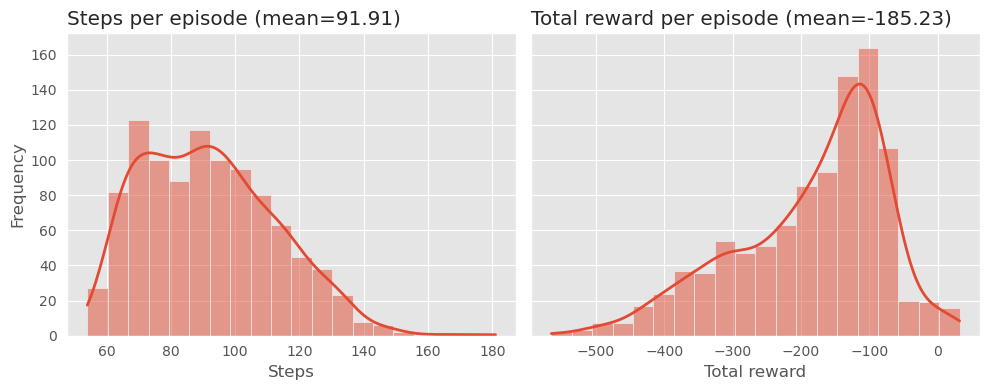

In [31]:
# Plotting the results
def plot_results_hist(n_steps, total_rewards):
    fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
    sns.histplot(x=n_steps, ax=ax[0], bins=20, kde=True)
    ax[0].set_title(f'Steps per episode (mean={n_steps.mean():.2f})')
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Frequency')
    sns.histplot(x=total_rewards, ax=ax[1], bins=20, kde=True)
    ax[1].set_title(f'Total reward per episode (mean={total_rewards.mean():.2f})')
    ax[1].set_xlabel('Total reward')
    ax[1].set_ylabel('Frequency')
    fig.tight_layout()
    plt.show()
    
plot_results_hist(n_steps, total_rewards)

# Reference agent: DQN

### Experience replay buffer

In [108]:
class experienceReplayBuffer:
    def __init__(self, memory_size=5000, burn_in=1000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32, device='cpu'):
        '''Sample a batch of experiences from the replay memory and return it as a tuple of tensors'''
        samples = random.sample(self.replay_memory, k=batch_size)
        states = torch.FloatTensor(np.vstack([e.state for e in samples])).to(device)
        actions = torch.LongTensor(np.vstack([e.action for e in samples])).to(device)
        rewards = torch.FloatTensor(np.vstack([e.reward for e in samples])).to(device)
        dones = torch.ByteTensor(np.vstack([e.done for e in samples]).astype(np.uint8)).to(device)
        next_states = torch.FloatTensor(np.vstack([e.next_state for e in samples])).to(device)
        return (states, actions, rewards, dones, next_states)

    def append(self, state, action, reward, done, next_state):
        '''Add a new experience to memory.'''
        exp = self.experience(state, action, reward, done, next_state)
        self.replay_memory.append(exp)

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### Neural network

In [109]:
class DQN_NN(nn.Module):
    
    def __init__(self, n_inputs, n_hl1, n_hl2, n_outputs):
        super().__init__()
        """
        Params
        ======
        n_inputs: number of inputs
        n_hl1: number of units in the first hidden layer
        n_hl2: number of units in the second hidden layer
        n_outputs: number of outputs
        """
        self.n_inputs = n_inputs
        self.n_hl1 = n_hl1
        self.n_hl2 = n_hl2
        self.n_outputs = n_outputs
        
        self.fc1 = nn.Sequential(
            nn.Linear(self.n_inputs, self.n_hl1),
            nn.ReLU(),
            nn.Linear(self.n_hl1, self.n_hl2),
            nn.ReLU(),
            nn.Linear(self.n_hl2, self.n_outputs)
        )


    def forward(self, x):
        '''Forward pass through the network'''
        return self.fc1(x)
    
    
    def get_qvals(self, state):
        '''Returns the q-values for a given state'''
        if state.dim == 1:
            state = torch.unsqueeze(state, 0)
        return self.forward(state)
    

Test the NN.

In [60]:
env = gym.make('LunarLander-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DQN_NN(n_inputs=env.observation_space.shape[0], n_hl1=64, n_hl2=64, 
             n_outputs=env.action_space.n).to(device)
obs = env.reset()[0]
obs_tensor = torch.Tensor(obs).to(device).unsqueeze(0)
print(f'Input tensor to the NN: {obs_tensor.shape}')
output = net(obs_tensor)
print(f'Output tensor:{output}')
print(f'Output tensor shape:{output.shape}')

Input tensor to the NN: torch.Size([1, 8])
Output tensor:tensor([[ 0.1646, -0.0681, -0.0364,  0.0904]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Output tensor shape:torch.Size([1, 4])


In [61]:
print('Network architecture:')
summary(net, input_size=(1,net.n_inputs))

Network architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             576
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 4]             260
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [111]:
class DQNAgent:

    def __init__(self, env, network, device, buffer, gamma=0.99, 
                batch_size=32, lr=0.001, nblock=100, writer=None):
        """"
        Params
        ======
        env: environment
        network: neural network
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        eps_min: minimum epsilon
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        device: dispositivo
        actions: array de acciones posibles
        """

        self.env = env
        self.main_network = network
        self.target_network = deepcopy(network)
        
        self.buffer = buffer
        self.writer = writer
        self.gamma = gamma
        self.batch_size = batch_size
        self.nblock = nblock
        self.device = device
        
        # Action space
        self.actions = [i for i in range(self.env.action_space.n)]
        
        # Set optimizer for the main network
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=lr)
        
        # Initialize lists to store the results
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.epsilons = []
        self.losses = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        
        self.state0 = self.env.reset()[0]
        
    
    ### e-greedy method
    def get_action(self, state, epsilon=0.0):
        '''Return an action using an epsilon-greedy policy
        
             Params
            ======
            state (array_like): current state
            epsilon (float): epsilon, for epsilon-greedy action selection
        '''
        
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            state = torch.Tensor(state).unsqueeze(0).to(self.device)
            self.main_network.eval()
            with torch.inference_mode():
                qvals = self.main_network(state)
            self.main_network.train()
            action= torch.argmax(qvals, dim=-1).cpu().item()
        return action


    def take_step(self, eps, mode='train'):
        # Get random action
        if mode == 'explore':
            action = self.env.action_space.sample()  
        # Get action from q-values
        else:
            action = self.get_action(self.state0, eps)
            self.step_count += 1

        #Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, done, _, _ = self.env.step(action)
        self.total_reward += reward
        # Save experience in buffer
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state

        # Reset environment 'if done'
        if done:
            self.state0 = self.env.reset()[0]
        return done


    def train(self, max_episodes=5000, min_episodios=250, max_t=1000,
              batch_size=32, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              dnn_update_frequency=4, dnn_sync_frequency=1000):
        
        epsilon = eps_start
        
        # Fill the replay buffer with random experiences
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(epsilon, mode='explore')
        print("Replay buffer filled.")
        
        # Training loop
        print("Training...")
        episode, training = 0, True
        pbar = tqdm(desc='Training', total=max_episodes)
        
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            pbar.update(1)
            # Play an episode
            for t in range(max_t):
                # Take action in train mode (epsilon-greedy policy)
                gamedone = self.take_step(epsilon, mode='train')
                # Update the main network
                if not self.step_count % dnn_update_frequency:
                    self.update()
                # Target and main network syncronization
                if not self.step_count % dnn_sync_frequency:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)
                if gamedone:
                    break

            episode += 1
            # Save epsilon, loss, training reward and mean training reward
            self.training_rewards.append(self.total_reward)
            self.epsilons.append(epsilon)
            ep_loss = np.mean(np.array(self.update_loss))
            self.losses.append(ep_loss)
            mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(mean_rewards)
            
            # Add to tensorboard
            if self.writer is not None:
                self.writer.add_scalar("epsilon", epsilon, episode)
                self.writer.add_scalar("loss", ep_loss, episode)
                self.writer.add_scalar("reward", self.total_reward, episode)
                self.writer.add_scalar("mean_reward", mean_rewards, episode)
            
            self.update_loss = []

            print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Loss {:.2f}\t\t".format(
                episode, mean_rewards, epsilon, ep_loss), end="")

            # Check if the episode limit has been reached
            if episode >= max_episodes:
                training = False
                print('Episode limit reached.')
                break

            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            # y se ha entrenado un mínimo de episodios
            if mean_rewards >= self.env.spec.reward_threshold and min_episodios < episode:
                training = False
                print(f'Environment solved in {episode} episodes!')
                break

            # Epsilon update
            epsilon = max(epsilon * eps_decay, eps_end)


    def calculate_loss(self, batch):
        # We extract the states, actions, rewards, dones and next_states from the batch
        states, actions, rewards, dones, next_states = batch
        # Get q-values for all actions in current states
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions)
        # Get max q-values for next states from target network
        qvals_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        # Q-vals to 0 in terminal states
        qvals_next[dones] = 0
        # Bellman equation
        expected_qvals = self.gamma * qvals_next + rewards
        # Loss calculation
        loss = F.mse_loss(qvals, expected_qvals.reshape(-1,1))
        return loss


    def update(self):
        # Reset gradients
        self.optimizer.zero_grad()
        # Take a random batch from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size, device=self.device)
        # Calculate loss
        loss = self.calculate_loss(batch)
        # Backpropagate loss
        loss.backward()
        # Update network weights with gradients
        self.optimizer.step()
        # Save loss
        self.update_loss.append(loss.detach().to('cpu').item())

### Entrenamiento del agente

In [112]:
LR = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
BURN_IN = 1000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 500   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)

EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
EPSILON_MIN = 0.01    #Valor mínimo de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman

BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal

DNN_UPD = 10          #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

In [114]:
# Set environment
env = gym.make('LunarLander-v2')
# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# SummaryWriter to send to TensorBoard
writer = SummaryWriter(Path('runs') / 'DQN' / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Define agent's memory replay buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Define network
net = DQN_NN(n_inputs=env.observation_space.shape[0], n_hl1=64, n_hl2=64, 
             n_outputs=env.action_space.n).to(device)
writer.add_graph(net, torch.Tensor(env.reset()[0]).to(device).unsqueeze(0))


# Define agent
DQN_agent = DQNAgent(env, net, device, buffer, gamma=GAMMA, lr = LR,
                     batch_size=BATCH_SIZE, nblock=100, writer=writer)

Using device: cuda


In [106]:
DQN_agent.train(max_episodes=1000, min_episodios=250, max_t=500,
              batch_size=32, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              dnn_update_frequency=4, dnn_sync_frequency=1000)

Filling replay buffer...
Replay buffer filled.
Training...


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Episode 1 Mean Rewards -404.57 Epsilon 0.0770043145805155 , Loss 218.36		

/tmp/ipykernel_4721/1020612125.py:170: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Indexing.cu:1239.)
  qvals_next[dones] = 0


Episode 138 Mean Rewards -238.24 Epsilon 0.019432859888279527 , Loss 8.34			

KeyboardInterrupt: 

In [ ]:
def plot_results(rewards, mean_rewards, reward_threshold, losses, epsilon):
    sns.set_style('darkgrid')
    n = len([met for met in [rewards, losses, epsilon] if met is not None])
    fig, ax = plt.subplots(n, 1, figsize=(10, n*3), sharex=True)
    # Rewards
    episodes = range(len(rewards))
    sns.lineplot(x=episodes, y=rewards, label='Reward', ax=ax[0], lw=0.5, alpha=0.5)
    sns.lineplot(x=episodes, y=mean_rewards, label='Mean reward', ax=ax[0], lw=1)
    sns.lineplot(x=episodes, y=reward_threshold, label='Reward threshold', ax=ax[0])
    ax[0].set_title('Rewards vs. Episodes')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    # Losses
    sns.lineplot(x=episodes, y=losses, ax=ax[1], lw=1)
    ax[1].set_title('Losses vs. Episodes')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Loss')
    plt.tight_layout()
    # Epsilon
    if epsilon is not None:
        sns.lineplot(x=episodes, y=epsilon, ax=ax[2])
        ax[2].set_title('Epsilon vs. Episodes')
        ax[2].set_xlabel('Episodes')
        ax[2].set_ylabel('Epsilon value')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_results(rewards = DQN_agent.training_rewards, 
             mean_rewards = DQN_agent.mean_training_rewards, 
             reward_threshold = DQN_agent.env.reward_threshold,
             losses = DQN_agent.losses,
             epsilon = DQN_agent.epsilons)

Hyperparameter tuning

In [ ]:
dqn_param_gs = {
    'LR': [0.001, 0.0001, 0.00001],
    'MEMORY_SIZE': [8000, 16000, 32000],
    'DNN_UPD': [10, 20, 50],
    'DNN_SYNC': [5000, 10000, 20000],
    'BATCH_SIZE': [32, 64, 128]
}

def train_dqn_agent(env, dqn_agent, param_grid, max_episodes=MAX_EPISODES, 
                    nblock=100, min_episodes=100, 
                    writer=None):
    # Grid search
    for lr in param_grid['LR']:
        for memory_size in param_grid['MEMORY_SIZE']:
            for dnn_upd in param_grid['DNN_UPD']:
                for dnn_sync in param_grid['DNN_SYNC']:
                    for batch_size in param_grid['BATCH_SIZE']:
                        # Define agent's memory replay buffer
                        buffer = experienceReplayBuffer(memory_size=memory_size, burn_in=BURN_IN)
                        # Define agent
                        dqn_agent = DQN_Agent(env, net, optimizer, buffer, epsilon=EPSILON)
                        # Train agent
                        dqn_agent.train(max_episodes=max_episodes, nblock=nblock, 
                                        min_episodes=min_episodes, writer=writer)
                        # Save agent
                        torch.save(dqn_agent, 'dqn_agent_{}_{}_{}_{}_{}.pth'.format(lr, memory_size, dnn_upd, dnn_sync, batch_size))
                        # Clear agent
                        del dqn_agent
                        del buffer
                        torch.cuda.empty_cache()

# Proposed agent